**Mount the Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Unzip the Data**

In [2]:
!unzip '/content/gdrive/My Drive/MonuSegPatch.zip'

Archive:  /content/gdrive/My Drive/MonuSegPatch.zip
replace ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH0.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH1.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH10.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH11.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH12.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH13.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH14.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH15.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH16.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A

**Set the tensorflow to the to 1.x version**

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Clone the Github Repository and Rename it**

In [4]:
!git clone https://github.com/arslanamin14/Image-Segmentation.git
!mv Image-Segmentation Segmentation

Cloning into 'Image-Segmentation'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 164 (delta 26), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (164/164), 29.42 MiB | 9.40 MiB/s, done.
Resolving deltas: 100% (52/52), done.
mv: cannot move 'Image-Segmentation' to 'Segmentation/Image-Segmentation': Directory not empty


**Import the libraries**

In [5]:
from __future__ import print_function
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from tensorflow.python.keras.models import Model
from keras import backend as K

Using TensorFlow backend.


**Parameters for Image Resolution**

In [0]:
im_width = 256
im_height = 256

**Function to load Images and Masks**

In [0]:
def get_images(parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
  tissue_dir = parent_dir + img_folder
  gt_dir = parent_dir + gt_folder
  im_width, im_height = im_shape
  ids = next(os.walk(tissue_dir))[2]
  print("No. of images = ", len(ids))
  X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
  y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
  # tqdm is used to display the progress bar
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(tissue_dir+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0]
    mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
    if gt_extension:
      mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
    mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  return X, y

**Load the testing images and mask**

In [8]:
X_test, y_test = get_images("ModMonuSeg/Test/", (im_width, im_height), gt_extension='png')

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


**Define the functions of Dice, Precision, Recall and F1**

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

binary_crossentropy = "binary_crossentropy"


**Compile the Model**

In [10]:
from Segmentation.Models import UNET
input_img = Input((im_height, im_width, 3), name='img')
model = UNET.get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", f1_m, precision_m, recall_m, dice_coef])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Load the model weights**

In [0]:
model.load_weights('/content/Segmentation/Trained Model Weights/model-unet.h5')

**Evaluate on test dataset set and print the results**

In [13]:
loss, accuracy, f1_score, precision, recall , dice_score = model.evaluate(X_test, y_test, verbose=1)
print("unet_loss:", loss)
print("unet_Accuracy:", accuracy)
print("unet_f1_score:", f1_score)
print("unet_dice_score:", dice_score)

504/504 [==============================] - 3s 7ms/step
unet_loss: 0.29810921587641276
unet_Accuracy: 0.9054552723491003
unet_f1_score: 0.7715466959135873
unet_dice_score: 0.9587489205693441


**Predict on train and test**

In [14]:
preds_test = model.predict(X_test, verbose=1)

504/504 [==============================] - 1s 2ms/step


**Threshold predictions**

In [0]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

**Threshold predictions**

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)
    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

**Testing Images With Ground Truth and Predicted**

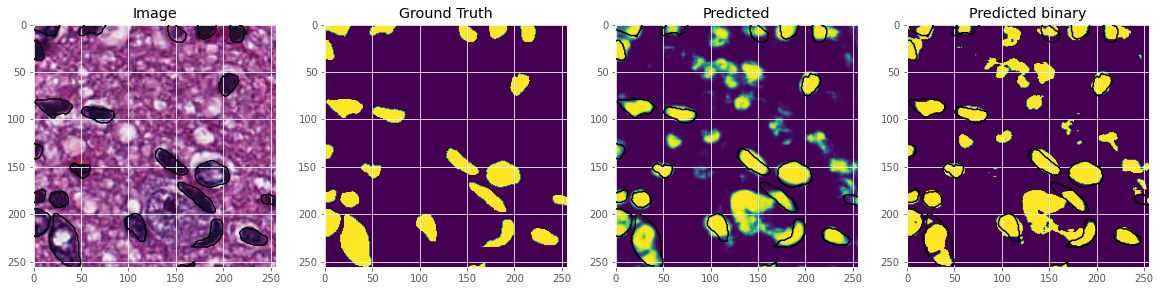

In [17]:
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=10)